# Tensorflow CNN for Cifar-10
An implementation of deep CNN for cifar-10 image dataset.

## Basic Preparation
### Imports

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
# needed by all conv net
from keras.layers import GlobalAveragePooling2D

Using TensorFlow backend.


### Download Dataset

In [3]:
%%bash

pwd
rm -rf cifar-10
mkdir cifar-10
cd cifar-10
wget -nv http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
ls -l

/content
total 166504
-rw-r--r-- 1 root root 170498071 Jun  4  2009 cifar-10-python.tar.gz


2018-05-20 11:36:52 URL:http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz [170498071/170498071] -> "cifar-10-python.tar.gz" [1]


### Extract Data

In [4]:
%%bash
pwd
cd cifar-10
rm -rf cifar-10-batches-py
tar xvf cifar-10-python.tar.gz
ls -l cifar-10-batches-py

/content
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


### Check GPU

In [0]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

### Constants Used

In [0]:
PATH = "cifar-10/cifar-10-batches-py/"
SIZE = 32
CHANNELS = 3
NUM_CLASSES = 10
IMAGE_BATCH = 10000
NUM_FILES_TRAIN = 5
# total number of training images
IMAGE_TRAIN = IMAGE_BATCH * NUM_FILES_TRAIN

### Hyperparameters

In [0]:
NUM_EPOCH = 100
# turns out that 23 epoch is enough
# this learning rate is too small
# LEARN_RATE = 1.0e-4
# use the default learning rate of keras.optimizers.Adam

### Helper Functions

In [0]:
# helper functions for cifar-10 dataset
import pickle
import numpy as np
from keras.utils import np_utils

#### Helper functons for data processing

In [0]:
def unpickle(file):
  # convert byte stream to object
  with open(PATH + file, 'rb') as fo:
    print("Decoding file: %s" % (PATH + file))
    data_dict = pickle.load(fo, encoding="bytes")
    # get a dictionary with images(features) and labels
  
  return data_dict

def convert_images(raw_images):
  # convert images to numpy array, and normalize it
  raw = np.array(raw_images, dtype=float) / 255.0
  # reshape to 4 dimension
  images = raw.reshape([-1, CHANNELS, SIZE, SIZE])
  images = images.transpose([0, 2, 3, 1])
  # now [image_num, height, weight, CHANNELS]
  return images

def load_data(file):
  # load file, unpickle it and return images with their labels
  data = unpickle(file)
  # get images
  images_array = data[b'data']
  images = convert_images(images_array)
  labels = np.array(data[b'labels'])
  # return in np array form
  return images, labels

In [0]:
def get_test_data():
  # load all test data
  
  images, labels = load_data(file="test_batch")
  # return images, labels, and one-hot arrays
  return images, labels, np_utils.to_categorical(labels, NUM_CLASSES)

def get_train_data():
  # load all training data in 5 files
  
  images = np.zeros([IMAGE_TRAIN, SIZE, SIZE, CHANNELS], dtype=float)
  labels = np.zeros([IMAGE_TRAIN], dtype=int)
  start = 0
  for i in range(NUM_FILES_TRAIN):
    images_batch, labels_batch = load_data(file="data_batch_" + str(i+1))
    end = start + IMAGE_BATCH
    # put the batch into the array
    images[start:end, :] = images_batch
    labels[start:end] = labels_batch
    start = end
   
  # return images, labels, and the corresponding one-hot arrays
  return images, labels, np_utils.to_categorical(labels, NUM_CLASSES)

def get_class_names():
  # get all the class names
  
  raw = unpickle("batches.meta")[b'label_names']
  names = [x.decode('utf-8') for x in raw]
  return names

#### Helper functions for data visualization

In [0]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

## Fetch Data

load the dataset for training and testing

In [11]:
x_train, y_train, class_train = get_train_data()

Decoding file: cifar-10/cifar-10-batches-py/data_batch_1
Decoding file: cifar-10/cifar-10-batches-py/data_batch_2
Decoding file: cifar-10/cifar-10-batches-py/data_batch_3
Decoding file: cifar-10/cifar-10-batches-py/data_batch_4
Decoding file: cifar-10/cifar-10-batches-py/data_batch_5


In [12]:
x_test, y_test, class_test = get_test_data()

Decoding file: cifar-10/cifar-10-batches-py/test_batch


## CNN Model with Keras
Here we use all-conv net

### Model Definition

In [0]:
def get_all_conv_net():
  model = Sequential()
  model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(SIZE, SIZE, CHANNELS)))
  model.add(Dropout(0.2))

  model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
  model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
  model.add(Dropout(0.5))
    
  model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
  model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
  model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
  model.add(Dropout(0.5))    
    
  model.add(Conv2D(192, (3, 3), padding = 'same'))
  model.add(Activation('relu'))
  model.add(Conv2D(192, (1, 1),padding='valid'))
  model.add(Activation('relu'))
  model.add(Conv2D(10, (1, 1), padding='valid'))

  model.add(GlobalAveragePooling2D())
    
  model.add(Activation('softmax'))

  model.summary()
    
  return model

In [15]:
model = get_all_conv_net()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 192)       331968    
__________

### Model Training

Train the model on the training data, and save it after every epoch

In [0]:
checkPoint = ModelCheckpoint("all_conv_net.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="auto")

Configure the model for training

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=LEARN_RATE), metrics=['accuracy'])
# use adam optimizer for better performance, and evaluate the accuracy

Fit the model on the data

In [18]:
model_details = model.fit(x_train, class_train, batch_size=128, epochs=NUM_EPOCH, validation_data=(x_test, class_test), callbacks=[checkPoint], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 60s 1ms/step - loss: 1.8553 - acc: 0.2830 - val_loss: 1.5267 - val_acc: 0.4262

Epoch 00001: val_loss improved from inf to 1.52673, saving model to all_conv_net.h5
Epoch 2/100
14720/50000 [=======>......................] - ETA: 37s - loss: 1.5282 - acc: 0.4270

50000/50000 [==============================] - 57s 1ms/step - loss: 1.4214 - acc: 0.4700 - val_loss: 1.2982 - val_acc: 0.5185

Epoch 00002: val_loss improved from 1.52673 to 1.29815, saving model to all_conv_net.h5
Epoch 3/100
31488/50000 [=================>............] - ETA: 19s - loss: 1.2161 - acc: 0.5526

50000/50000 [==============================] - 57s 1ms/step - loss: 1.1877 - acc: 0.5620 - val_loss: 1.0921 - val_acc: 0.6035

Epoch 00003: val_loss improved from 1.29815 to 1.09215, saving model to all_conv_net.h5
Epoch 4/100
35968/50000 [====================>.........] - ETA: 15s - loss: 1.0537 - acc: 0.6185

50000/50000 [==============================] - 57s 1ms/step - loss: 1.0392 - acc: 0.6255 - val_loss: 0.9709 - val_acc: 0.6516

Epoch 00004: val_loss improved from 1.09215 to 0.97090, saving model to all_conv_net.h5
Epoch 5/100
37120/50000 [=====================>........] - ETA: 13s - loss: 0.9342 - acc: 0.6613

50000/50000 [==============================] - 57s 1ms/step - loss: 0.9289 - acc: 0.6648 - val_loss: 0.8564 - val_acc: 0.6940

Epoch 00005: val_loss improved from 0.97090 to 0.85641, saving model to all_conv_net.h5
Epoch 6/100
37504/50000 [=====================>........] - ETA: 13s - loss: 0.8451 - acc: 0.7007

50000/50000 [==============================] - 57s 1ms/step - loss: 0.8362 - acc: 0.7031 - val_loss: 0.7932 - val_acc: 0.7240

Epoch 00006: val_loss improved from 0.85641 to 0.79320, saving model to all_conv_net.h5
Epoch 7/100
37632/50000 [=====================>........] - ETA: 13s - loss: 0.7781 - acc: 0.7248

50000/50000 [==============================] - 57s 1ms/step - loss: 0.7764 - acc: 0.7257 - val_loss: 0.8148 - val_acc: 0.7073

Epoch 00007: val_loss did not improve from 0.79320
Epoch 8/100
42880/50000 [========================>.....] - ETA: 7s - loss: 0.7173 - acc: 0.7448

50000/50000 [==============================] - 57s 1ms/step - loss: 0.7152 - acc: 0.7456 - val_loss: 0.6816 - val_acc: 0.7622

Epoch 00008: val_loss improved from 0.79320 to 0.68164, saving model to all_conv_net.h5
Epoch 9/100
39040/50000 [======================>.......] - ETA: 11s - loss: 0.6632 - acc: 0.7663

50000/50000 [==============================] - 57s 1ms/step - loss: 0.6616 - acc: 0.7667 - val_loss: 0.6462 - val_acc: 0.7790

Epoch 00009: val_loss improved from 0.68164 to 0.64616, saving model to all_conv_net.h5
Epoch 10/100
37888/50000 [=====================>........] - ETA: 13s - loss: 0.6257 - acc: 0.7791

50000/50000 [==============================] - 57s 1ms/step - loss: 0.6267 - acc: 0.7797 - val_loss: 0.6512 - val_acc: 0.7745

Epoch 00010: val_loss did not improve from 0.64616
Epoch 11/100
42752/50000 [========================>.....] - ETA: 7s - loss: 0.5943 - acc: 0.7908

50000/50000 [==============================] - 57s 1ms/step - loss: 0.5922 - acc: 0.7920 - val_loss: 0.6127 - val_acc: 0.7906

Epoch 00011: val_loss improved from 0.64616 to 0.61274, saving model to all_conv_net.h5
Epoch 12/100
38912/50000 [======================>.......] - ETA: 11s - loss: 0.5569 - acc: 0.8055

50000/50000 [==============================] - 57s 1ms/step - loss: 0.5604 - acc: 0.8042 - val_loss: 0.6022 - val_acc: 0.7952

Epoch 00012: val_loss improved from 0.61274 to 0.60222, saving model to all_conv_net.h5
Epoch 13/100
37888/50000 [=====================>........] - ETA: 13s - loss: 0.5277 - acc: 0.8143

50000/50000 [==============================] - 57s 1ms/step - loss: 0.5312 - acc: 0.8132 - val_loss: 0.5855 - val_acc: 0.8004

Epoch 00013: val_loss improved from 0.60222 to 0.58546, saving model to all_conv_net.h5
Epoch 14/100
37632/50000 [=====================>........] - ETA: 13s - loss: 0.5090 - acc: 0.8206

50000/50000 [==============================] - 57s 1ms/step - loss: 0.5118 - acc: 0.8202 - val_loss: 0.5587 - val_acc: 0.8117

Epoch 00014: val_loss improved from 0.58546 to 0.55866, saving model to all_conv_net.h5
Epoch 15/100
37504/50000 [=====================>........] - ETA: 13s - loss: 0.4882 - acc: 0.8299

50000/50000 [==============================] - 57s 1ms/step - loss: 0.4943 - acc: 0.8272 - val_loss: 0.5690 - val_acc: 0.8053

Epoch 00015: val_loss did not improve from 0.55866
Epoch 16/100
42624/50000 [========================>.....] - ETA: 7s - loss: 0.4688 - acc: 0.8360

50000/50000 [==============================] - 57s 1ms/step - loss: 0.4674 - acc: 0.8367 - val_loss: 0.5362 - val_acc: 0.8212

Epoch 00016: val_loss improved from 0.55866 to 0.53624, saving model to all_conv_net.h5
Epoch 17/100
38784/50000 [======================>.......] - ETA: 12s - loss: 0.4488 - acc: 0.8415

50000/50000 [==============================] - 57s 1ms/step - loss: 0.4487 - acc: 0.8421 - val_loss: 0.5439 - val_acc: 0.8165

Epoch 00017: val_loss did not improve from 0.53624
Epoch 18/100
43008/50000 [========================>.....] - ETA: 7s - loss: 0.4250 - acc: 0.8495

50000/50000 [==============================] - 57s 1ms/step - loss: 0.4269 - acc: 0.8498 - val_loss: 0.5689 - val_acc: 0.8156

Epoch 00018: val_loss did not improve from 0.53624
Epoch 19/100
44288/50000 [=========================>....] - ETA: 6s - loss: 0.4149 - acc: 0.8542

50000/50000 [==============================] - 57s 1ms/step - loss: 0.4155 - acc: 0.8547 - val_loss: 0.5501 - val_acc: 0.8147

Epoch 00019: val_loss did not improve from 0.53624
Epoch 20/100
44672/50000 [=========================>....] - ETA: 5s - loss: 0.3991 - acc: 0.8607

50000/50000 [==============================] - 57s 1ms/step - loss: 0.4001 - acc: 0.8599 - val_loss: 0.5532 - val_acc: 0.8151

Epoch 00020: val_loss did not improve from 0.53624
Epoch 21/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.3849 - acc: 0.8642

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3847 - acc: 0.8639 - val_loss: 0.5316 - val_acc: 0.8281

Epoch 00021: val_loss improved from 0.53624 to 0.53159, saving model to all_conv_net.h5
Epoch 22/100
39424/50000 [======================>.......] - ETA: 11s - loss: 0.3679 - acc: 0.8713

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3716 - acc: 0.8698 - val_loss: 0.5195 - val_acc: 0.8334

Epoch 00022: val_loss improved from 0.53159 to 0.51951, saving model to all_conv_net.h5
Epoch 23/100
38016/50000 [=====================>........] - ETA: 12s - loss: 0.3604 - acc: 0.8737

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3594 - acc: 0.8740 - val_loss: 0.5154 - val_acc: 0.8381

Epoch 00023: val_loss improved from 0.51951 to 0.51537, saving model to all_conv_net.h5
Epoch 24/100
37632/50000 [=====================>........] - ETA: 13s - loss: 0.3508 - acc: 0.8755

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3507 - acc: 0.8756 - val_loss: 0.5415 - val_acc: 0.8264

Epoch 00024: val_loss did not improve from 0.51537
Epoch 25/100
42624/50000 [========================>.....] - ETA: 7s - loss: 0.3269 - acc: 0.8838

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3325 - acc: 0.8817 - val_loss: 0.5201 - val_acc: 0.8368

Epoch 00025: val_loss did not improve from 0.51537
Epoch 26/100
44160/50000 [=========================>....] - ETA: 6s - loss: 0.3229 - acc: 0.8848

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3254 - acc: 0.8846 - val_loss: 0.5178 - val_acc: 0.8384

Epoch 00026: val_loss did not improve from 0.51537
Epoch 27/100
44672/50000 [=========================>....] - ETA: 5s - loss: 0.3165 - acc: 0.8873

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3166 - acc: 0.8872 - val_loss: 0.5388 - val_acc: 0.8323

Epoch 00027: val_loss did not improve from 0.51537
Epoch 28/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.3159 - acc: 0.8877

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3145 - acc: 0.8882 - val_loss: 0.5283 - val_acc: 0.8369

Epoch 00028: val_loss did not improve from 0.51537
Epoch 29/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.3077 - acc: 0.8898

50000/50000 [==============================] - 57s 1ms/step - loss: 0.3071 - acc: 0.8893 - val_loss: 0.5443 - val_acc: 0.8328

Epoch 00029: val_loss did not improve from 0.51537
Epoch 30/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2878 - acc: 0.8983

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2874 - acc: 0.8982 - val_loss: 0.5218 - val_acc: 0.8393

Epoch 00030: val_loss did not improve from 0.51537
Epoch 31/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2847 - acc: 0.8967

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2841 - acc: 0.8971 - val_loss: 0.5500 - val_acc: 0.8373

Epoch 00031: val_loss did not improve from 0.51537
Epoch 32/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2793 - acc: 0.9000

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2795 - acc: 0.8997 - val_loss: 0.5172 - val_acc: 0.8404

Epoch 00032: val_loss did not improve from 0.51537
Epoch 33/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2674 - acc: 0.9040

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2682 - acc: 0.9039 - val_loss: 0.5457 - val_acc: 0.8303

Epoch 00033: val_loss did not improve from 0.51537
Epoch 34/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2604 - acc: 0.9077

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2641 - acc: 0.9062 - val_loss: 0.5325 - val_acc: 0.8280

Epoch 00034: val_loss did not improve from 0.51537
Epoch 35/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2591 - acc: 0.9044

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2601 - acc: 0.9042 - val_loss: 0.5343 - val_acc: 0.8339

Epoch 00035: val_loss did not improve from 0.51537
Epoch 36/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2470 - acc: 0.9105

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2480 - acc: 0.9105 - val_loss: 0.5782 - val_acc: 0.8315

Epoch 00036: val_loss did not improve from 0.51537
Epoch 37/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2479 - acc: 0.9109

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2477 - acc: 0.9112 - val_loss: 0.5549 - val_acc: 0.8495

Epoch 00037: val_loss did not improve from 0.51537
Epoch 38/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2375 - acc: 0.9142

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2378 - acc: 0.9139 - val_loss: 0.5245 - val_acc: 0.8391

Epoch 00038: val_loss did not improve from 0.51537
Epoch 39/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2369 - acc: 0.9152

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2385 - acc: 0.9146 - val_loss: 0.5471 - val_acc: 0.8372

Epoch 00039: val_loss did not improve from 0.51537
Epoch 40/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2304 - acc: 0.9177

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2322 - acc: 0.9174 - val_loss: 0.5494 - val_acc: 0.8432

Epoch 00040: val_loss did not improve from 0.51537
Epoch 41/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2259 - acc: 0.9184

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2279 - acc: 0.9178 - val_loss: 0.5519 - val_acc: 0.8428

Epoch 00041: val_loss did not improve from 0.51537
Epoch 42/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2219 - acc: 0.9184

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2227 - acc: 0.9184 - val_loss: 0.5654 - val_acc: 0.8411

Epoch 00042: val_loss did not improve from 0.51537
Epoch 43/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2215 - acc: 0.9212

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2210 - acc: 0.9215 - val_loss: 0.5457 - val_acc: 0.8448

Epoch 00043: val_loss did not improve from 0.51537
Epoch 44/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2132 - acc: 0.9222

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2158 - acc: 0.9215 - val_loss: 0.5469 - val_acc: 0.8465

Epoch 00044: val_loss did not improve from 0.51537
Epoch 45/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2142 - acc: 0.9239

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2135 - acc: 0.9239 - val_loss: 0.5539 - val_acc: 0.8425

Epoch 00045: val_loss did not improve from 0.51537
Epoch 46/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2136 - acc: 0.9237

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2151 - acc: 0.9228 - val_loss: 0.5350 - val_acc: 0.8477

Epoch 00046: val_loss did not improve from 0.51537
Epoch 47/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2029 - acc: 0.9275

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2054 - acc: 0.9269 - val_loss: 0.5875 - val_acc: 0.8314

Epoch 00047: val_loss did not improve from 0.51537
Epoch 48/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2058 - acc: 0.9259

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2054 - acc: 0.9262 - val_loss: 0.5874 - val_acc: 0.8390

Epoch 00048: val_loss did not improve from 0.51537
Epoch 49/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2053 - acc: 0.9262

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2033 - acc: 0.9271 - val_loss: 0.6112 - val_acc: 0.8453

Epoch 00049: val_loss did not improve from 0.51537
Epoch 50/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.2062 - acc: 0.9264

50000/50000 [==============================] - 57s 1ms/step - loss: 0.2059 - acc: 0.9268 - val_loss: 0.5814 - val_acc: 0.8483

Epoch 00050: val_loss did not improve from 0.51537
Epoch 51/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1916 - acc: 0.9314

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1934 - acc: 0.9304 - val_loss: 0.5822 - val_acc: 0.8427

Epoch 00051: val_loss did not improve from 0.51537
Epoch 52/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1940 - acc: 0.9305

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1951 - acc: 0.9301 - val_loss: 0.5840 - val_acc: 0.8427

Epoch 00052: val_loss did not improve from 0.51537
Epoch 53/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1917 - acc: 0.9314

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1937 - acc: 0.9306 - val_loss: 0.5754 - val_acc: 0.8479

Epoch 00053: val_loss did not improve from 0.51537
Epoch 54/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1920 - acc: 0.9306

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1917 - acc: 0.9309 - val_loss: 0.5930 - val_acc: 0.8396

Epoch 00054: val_loss did not improve from 0.51537
Epoch 55/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1875 - acc: 0.9332

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1867 - acc: 0.9334 - val_loss: 0.5925 - val_acc: 0.8464

Epoch 00055: val_loss did not improve from 0.51537
Epoch 56/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1799 - acc: 0.9356

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1817 - acc: 0.9346 - val_loss: 0.6532 - val_acc: 0.8404

Epoch 00056: val_loss did not improve from 0.51537
Epoch 57/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1812 - acc: 0.9361

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1849 - acc: 0.9348 - val_loss: 0.6017 - val_acc: 0.8359

Epoch 00057: val_loss did not improve from 0.51537
Epoch 58/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1809 - acc: 0.9347

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1818 - acc: 0.9345 - val_loss: 0.6314 - val_acc: 0.8421

Epoch 00058: val_loss did not improve from 0.51537
Epoch 59/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1774 - acc: 0.9379

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1809 - acc: 0.9366 - val_loss: 0.5751 - val_acc: 0.8445

Epoch 00059: val_loss did not improve from 0.51537
Epoch 60/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1764 - acc: 0.9365

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1780 - acc: 0.9361 - val_loss: 0.5967 - val_acc: 0.8447

Epoch 00060: val_loss did not improve from 0.51537
Epoch 61/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1720 - acc: 0.9386

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1723 - acc: 0.9385 - val_loss: 0.5995 - val_acc: 0.8512

Epoch 00061: val_loss did not improve from 0.51537
Epoch 62/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1747 - acc: 0.9377

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1751 - acc: 0.9374 - val_loss: 0.6026 - val_acc: 0.8458

Epoch 00062: val_loss did not improve from 0.51537
Epoch 63/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1776 - acc: 0.9365

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1780 - acc: 0.9363 - val_loss: 0.6025 - val_acc: 0.8487

Epoch 00063: val_loss did not improve from 0.51537
Epoch 64/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1696 - acc: 0.9392

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1692 - acc: 0.9393 - val_loss: 0.6000 - val_acc: 0.8516

Epoch 00064: val_loss did not improve from 0.51537
Epoch 65/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1649 - acc: 0.9405

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1665 - acc: 0.9400 - val_loss: 0.6408 - val_acc: 0.8424

Epoch 00065: val_loss did not improve from 0.51537
Epoch 66/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1641 - acc: 0.9418

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1650 - acc: 0.9416 - val_loss: 0.6548 - val_acc: 0.8396

Epoch 00066: val_loss did not improve from 0.51537
Epoch 67/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1703 - acc: 0.9392

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1720 - acc: 0.9386 - val_loss: 0.5952 - val_acc: 0.8451

Epoch 00067: val_loss did not improve from 0.51537
Epoch 68/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1653 - acc: 0.9414

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1662 - acc: 0.9411 - val_loss: 0.6375 - val_acc: 0.8427

Epoch 00068: val_loss did not improve from 0.51537
Epoch 69/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1667 - acc: 0.9413

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1666 - acc: 0.9413 - val_loss: 0.6396 - val_acc: 0.8350

Epoch 00069: val_loss did not improve from 0.51537
Epoch 70/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1605 - acc: 0.9429

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1621 - acc: 0.9424 - val_loss: 0.6207 - val_acc: 0.8439

Epoch 00070: val_loss did not improve from 0.51537
Epoch 71/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1623 - acc: 0.9413

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1641 - acc: 0.9407 - val_loss: 0.6602 - val_acc: 0.8390

Epoch 00071: val_loss did not improve from 0.51537
Epoch 72/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1621 - acc: 0.9413

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1616 - acc: 0.9415 - val_loss: 0.6537 - val_acc: 0.8473

Epoch 00072: val_loss did not improve from 0.51537
Epoch 73/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1629 - acc: 0.9434

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1626 - acc: 0.9433 - val_loss: 0.6344 - val_acc: 0.8480

Epoch 00073: val_loss did not improve from 0.51537
Epoch 74/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1562 - acc: 0.9446

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1558 - acc: 0.9447 - val_loss: 0.6580 - val_acc: 0.8472

Epoch 00074: val_loss did not improve from 0.51537
Epoch 75/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1606 - acc: 0.9437

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1598 - acc: 0.9440 - val_loss: 0.6781 - val_acc: 0.8421

Epoch 00075: val_loss did not improve from 0.51537
Epoch 76/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1564 - acc: 0.9439

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1591 - acc: 0.9432 - val_loss: 0.6276 - val_acc: 0.8447

Epoch 00076: val_loss did not improve from 0.51537
Epoch 77/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1549 - acc: 0.9444

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1558 - acc: 0.9440 - val_loss: 0.6271 - val_acc: 0.8500

Epoch 00077: val_loss did not improve from 0.51537
Epoch 78/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1542 - acc: 0.9468

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1537 - acc: 0.9468 - val_loss: 0.6206 - val_acc: 0.8459

Epoch 00078: val_loss did not improve from 0.51537
Epoch 79/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1534 - acc: 0.9460

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1557 - acc: 0.9455 - val_loss: 0.6237 - val_acc: 0.8458

Epoch 00079: val_loss did not improve from 0.51537
Epoch 80/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1537 - acc: 0.9452

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1578 - acc: 0.9444 - val_loss: 0.6380 - val_acc: 0.8418

Epoch 00080: val_loss did not improve from 0.51537
Epoch 81/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1536 - acc: 0.9448

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1545 - acc: 0.9448 - val_loss: 0.6416 - val_acc: 0.8464

Epoch 00081: val_loss did not improve from 0.51537
Epoch 82/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1495 - acc: 0.9473

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1507 - acc: 0.9468 - val_loss: 0.6919 - val_acc: 0.8356

Epoch 00082: val_loss did not improve from 0.51537
Epoch 83/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1521 - acc: 0.9452

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1528 - acc: 0.9451 - val_loss: 0.6620 - val_acc: 0.8388

Epoch 00083: val_loss did not improve from 0.51537
Epoch 84/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1511 - acc: 0.9468

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1514 - acc: 0.9465 - val_loss: 0.6402 - val_acc: 0.8453

Epoch 00084: val_loss did not improve from 0.51537
Epoch 85/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1479 - acc: 0.9484

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1505 - acc: 0.9473 - val_loss: 0.6188 - val_acc: 0.8497

Epoch 00085: val_loss did not improve from 0.51537
Epoch 86/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1481 - acc: 0.9481

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1463 - acc: 0.9488 - val_loss: 0.7058 - val_acc: 0.8439

Epoch 00086: val_loss did not improve from 0.51537
Epoch 87/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1505 - acc: 0.9475

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1488 - acc: 0.9481 - val_loss: 0.6932 - val_acc: 0.8465

Epoch 00087: val_loss did not improve from 0.51537
Epoch 88/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1530 - acc: 0.9458

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1546 - acc: 0.9453 - val_loss: 0.6311 - val_acc: 0.8473

Epoch 00088: val_loss did not improve from 0.51537
Epoch 89/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1438 - acc: 0.9501

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1459 - acc: 0.9495 - val_loss: 0.6766 - val_acc: 0.8431

Epoch 00089: val_loss did not improve from 0.51537
Epoch 90/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1505 - acc: 0.9473

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1506 - acc: 0.9472 - val_loss: 0.6621 - val_acc: 0.8464

Epoch 00090: val_loss did not improve from 0.51537
Epoch 91/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1390 - acc: 0.9519

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1415 - acc: 0.9509 - val_loss: 0.6954 - val_acc: 0.8347

Epoch 00091: val_loss did not improve from 0.51537
Epoch 92/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1446 - acc: 0.9499

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1484 - acc: 0.9485 - val_loss: 0.6441 - val_acc: 0.8490

Epoch 00092: val_loss did not improve from 0.51537
Epoch 93/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1464 - acc: 0.9480

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1464 - acc: 0.9479 - val_loss: 0.6403 - val_acc: 0.8510

Epoch 00093: val_loss did not improve from 0.51537
Epoch 94/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1431 - acc: 0.9498

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1457 - acc: 0.9490 - val_loss: 0.6693 - val_acc: 0.8440

Epoch 00094: val_loss did not improve from 0.51537
Epoch 95/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1420 - acc: 0.9503

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1406 - acc: 0.9506 - val_loss: 0.6809 - val_acc: 0.8434

Epoch 00095: val_loss did not improve from 0.51537
Epoch 96/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1380 - acc: 0.9516

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1397 - acc: 0.9510 - val_loss: 0.6937 - val_acc: 0.8441

Epoch 00096: val_loss did not improve from 0.51537
Epoch 97/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1461 - acc: 0.9481

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1464 - acc: 0.9479 - val_loss: 0.6412 - val_acc: 0.8484

Epoch 00097: val_loss did not improve from 0.51537
Epoch 98/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1367 - acc: 0.9519

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1384 - acc: 0.9512 - val_loss: 0.6480 - val_acc: 0.8482

Epoch 00098: val_loss did not improve from 0.51537
Epoch 99/100
44800/50000 [=========================>....] - ETA: 5s - loss: 0.1362 - acc: 0.9513

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1382 - acc: 0.9508 - val_loss: 0.7151 - val_acc: 0.8400

Epoch 00099: val_loss did not improve from 0.51537
Epoch 100/100
44672/50000 [=========================>....] - ETA: 5s - loss: 0.1364 - acc: 0.9509

50000/50000 [==============================] - 57s 1ms/step - loss: 0.1375 - acc: 0.9508 - val_loss: 0.6403 - val_acc: 0.8462

Epoch 00100: val_loss did not improve from 0.51537


In [19]:
%%bash
ls -al

total 16168
drwxr-xr-x 1 root root     4096 May 16 13:19 .
drwxr-xr-x 1 root root     4096 May 16 12:29 ..
-rw-r--r-- 1 root root 16506816 May 16 13:40 all_conv_net.h5
drwx------ 4 root root     4096 May 16 13:14 .cache
drwxr-xr-x 3 root root     4096 May 16 13:16 cifar-10
drwxr-xr-x 3 root root     4096 May 16 13:14 .config
drwxr-xr-x 1 root root     4096 Apr 30 16:29 datalab
drwxr-xr-x 4 root root     4096 May 16 12:30 .forever
drwxr-xr-x 5 root root     4096 May 16 13:14 .ipython
drwxr-xr-x 2 root root     4096 May 16 13:15 .keras
drwx------ 3 root root     4096 May 16 12:30 .local
drwx------ 3 root root     4096 May 16 13:15 .nv
-rw------- 1 root root     1024 May 16 12:30 .rnd


### Model Evaluation

In [20]:
scores = model.evaluate(x_test, class_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

10000/10000 [==============================] - 4s 423us/step
Accuracy: 84.62%


Plot model accuracy and loss

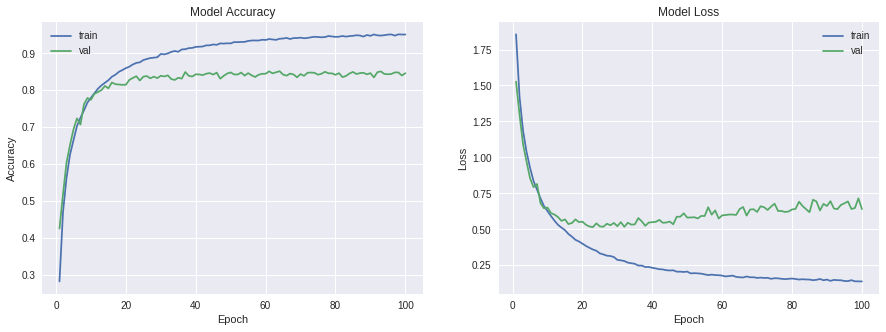

In [21]:
plot_model(model_details)

# Tensorflow implementation

In [0]:
import tensorflow as tf
import time

## Define some helper function to build layers

In [0]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name, stride=[1,1,1,1], pad='SAME'):
    
    with tf.variable_scope(name) as scope:
        # Shape of the filter-weights for the convolution
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights (filters) with the given shape
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))

        # Create new biases, one for each filter
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))

        # TensorFlow operation for convolution
        layer = tf.nn.conv2d(input=input, filter=weights, strides=stride, padding=pad)

        # Add the biases to the results of the convolution.
        layer += biases
        
        return layer, weights

In [0]:
def new_pool_layer (input, name):
    
    with tf.variable_scope(name) as scope:
        # TensorFlow operation for convolution
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        return layer

In [0]:
def new_relu_layer (input, name):
    
    with tf.variable_scope(name) as scope:
        # TensorFlow operation for convolution
        layer = tf.nn.relu(input)
        
        return layer

In [0]:
def new_fc_layer(input, num_inputs, num_outputs, name):
    
    with tf.variable_scope(name) as scope:

        # Create new weights and biases.
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        
        # Multiply the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases
        
        return layer

## Build the network

In [0]:
X = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='X')
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=0)

In [0]:
# Convolutional Layer 1
layer_conv1, weights_conv1 = new_conv_layer(input=X, num_input_channels=3, 
                                            filter_size=3, num_filters=96, name ="conv1")

# RelU layer 1
layer_relu1 = new_relu_layer(layer_conv1, name="relu1")

# Dropout Layer 1
layer_dropout1 = tf.nn.dropout(layer_relu1, keep_prob=0.8)

# Convolutional Layer 2
layer_conv2, weights_conv2 = new_conv_layer(input=layer_dropout1, num_input_channels=96, 
                                            filter_size=3, num_filters=96, name ="conv2")

# RelU layer 2
layer_relu2 = new_relu_layer(layer_conv2, name="relu2")

# Convolutional Layer 3
layer_conv3, weights_conv3 = new_conv_layer(input=layer_relu2, num_input_channels=96, 
                                            filter_size=3, num_filters=96, name ="conv3", stride=[1,2,2,1])

# RelU layer 3
layer_relu3 = new_relu_layer(layer_conv3, name="relu3")

# Dropout Layer 2
layer_dropout2 = tf.nn.dropout(layer_relu3, keep_prob=0.5)

# Convolutional Layer 4
layer_conv4, weights_conv4 = new_conv_layer(input=layer_dropout2, num_input_channels=96, 
                                            filter_size=3, num_filters=192, name ="conv4")

# RelU layer 4
layer_relu4 = new_relu_layer(layer_conv4, name="relu4")

# Convolutional Layer 5
layer_conv5, weights_conv5 = new_conv_layer(input=layer_relu4, num_input_channels=192, 
                                            filter_size=3, num_filters=192, name ="conv5")

# RelU layer 5
layer_relu5 = new_relu_layer(layer_conv5, name="relu5")


# Convolutional Layer 6
layer_conv6, weights_conv6 = new_conv_layer(input=layer_relu5, num_input_channels=192, 
                                            filter_size=3, num_filters=192, name ="conv6", stride=[1,2,2,1])

# RelU layer 6
layer_relu6 = new_relu_layer(layer_conv6, name="relu6")

# Dropout Layer 3
layer_dropout3 = tf.nn.dropout(layer_relu6, keep_prob=0.5)

# Convolutional Layer 7
layer_conv7, weights_conv7 = new_conv_layer(input=layer_dropout3, num_input_channels=192, 
                                            filter_size=3, num_filters=192, name ="conv7")

# RelU layer 7
layer_relu7 = new_relu_layer(layer_conv7, name="relu7")

# Convolutional Layer 8
layer_conv8, weights_conv8 = new_conv_layer(input=layer_relu7, num_input_channels=192, 
                                            filter_size=1, num_filters=192, name ="conv8", pad='VALID')

# RelU layer 8
layer_relu8 = new_relu_layer(layer_conv8, name="relu8")

# Convolutional Layer 9
layer_conv9, weights_conv9 = new_conv_layer(input=layer_relu8, num_input_channels=192, 
                                            filter_size=1, num_filters=10, name ="conv9", pad='VALID')

# Global Avg Pooling
layer_global_avg_pooling = tf.layers.average_pooling2d(layer_conv9, pool_size=8, strides=8)


In [22]:
# Use Cross entropy cost function
with tf.name_scope("cross_entropy"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_global_avg_pooling, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [0]:
# Use Adam Optimizer
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [0]:
with tf.variable_scope("prediction"):
    y_pred = tf.nn.softmax(layer_global_avg_pooling)
    y_pred_cls = tf.argmax(y_pred, axis=0)

# Accuracy
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Set the hyper parameters and start training

In [0]:
num_epochs = 100
batch_size = 128

In [0]:
saver = tf.train.Saver()

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Loop over number of epochs
    for epoch in range(num_epochs):
        
        start_time = time.time()
        train_accuracy = 0
        
        for batch in range(0, int(len(x_train)/batch_size)):
            
            # Get a batch of images and labels
            x_batch = x_train[batch*batch_size:(batch+1)*batch_size]
            y_true_batch = class_train[batch*batch_size:(batch+1)*batch_size]
            
            # Put the batch into a dict with the proper names for placeholder variables
            feed_dict_train = {X: x_batch, y_true: y_true_batch}
            
            # Run the optimizer using this batch of training data.
            sess.run(optimizer, feed_dict=feed_dict_train)
            
            # Calculate the accuracy on the batch of training data
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
        
          
        train_accuracy /= int(len(class_train)/batch_size)        

        end_time = time.time()
        
        print("Epoch "+str(epoch+1)+" completed : Time usage "+str(int(end_time-start_time))+" seconds")
        print("\tAccuracy:")
        print ("\t- Training Accuracy:\t{}".format(train_accuracy))
        
    test_accuracy = sess.run(accuracy, feed_dict={X:x_test, y_true:class_test})
    print ("Final test Accuracy:\t{}".format(test_accuracy))
    
    save_path = saver.save(sess, '/tmp/model.ckpt')

Epoch 1 completed : Time usage 72 seconds
	Accuracy:
	- Training Accuracy:	0.025128205521748617
Epoch 2 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.04102564171338693
Epoch 3 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.05282051368401601
Epoch 4 completed : Time usage 71 seconds
	Accuracy:
	- Training Accuracy:	0.0584615395237238
Epoch 5 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.056153847105227986
Epoch 6 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.061025642126034466
Epoch 7 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.060256411249821
Epoch 8 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.06358974474744919
Epoch 9 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.06307692416967489
Epoch 10 completed : Time usage 70 seconds
	Accuracy:
	- Training Accuracy:	0.06666666779380578
Epoch 11 completed : Time usage 70 seconds
	Accur